In [1]:
from tool import *
import missingno as msno

ModuleNotFoundError: No module named 'missingno'

## 1. DOA DB를 불러옴

In [3]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [14]:
df.fillna('TBD').pivot_table(values='S/N', index=['Vendor', 'DOA Number', 'FOC Number', 'Grouping Number', 'HBL', 'OBD'], aggfunc='count').fillna(0).convert_dtypes()

S/N
Vendor   DOA Number      FOC Number  Grouping Number HBL            OBD                     
Pegatron LG20230410      F1000208058 CPCZ2304110002  TBD            TBD                   14
         LG211006        F1000190536 CPCZ2110070006  SMCIA216103    2021-10-12 00:00:00   35
         LG211102        F1000191443 CPCZ2111030006  SMCIA216793    2021-11-09 00:00:00   26
         LG211201        F1000192504 CPCZ2112060001  SMCIA217762    2021-12-09 00:00:00   63
         LG220304        F1000195153 CPCZ2203070002  SEL-0052 9817  2022-03-17 00:00:00   51
         LG220510        F1000197493 CPCZ2205180002  SEL-0053 5903  2022-05-25 00:00:00   27
         LG220721        F1000199890 CPCZ2207290002  SEL-0054 0419  2022-08-01 00:00:00   39
         LG220818        F1000200869 CPCZ2209010002  988-40865871   2022-09-01 00:00:00  562
         LG221017        F1000202530 CPCZ2210200001  SEL-0054 5900  2022-10-23 00:00:00   42
         LG221108        F1000203191 CPCZ2211090008  5501 1591 8253 2022-11-13 00:00:00   45
         LG230308        F1000207121 CPCZ2303140001  SEL-0055 9015  2023-03-18 00:00:00   10
Quanta   N5T21916H-391   F1000190204 CPCZ2109280001  SMCIA215936    2021-10-07 00:00:00    8
         N5V21927H-391   F1000190524 CPCZ2110070001  SMCIA216102    2021-10-12 00:00:00  312
         N5V21B08H-391   F1000191764 CPCZ2111150001  SMCIA217109    2021-11-18 00:00:00  137
         N5V21B24H-391L  F1000192308 CPCZ2111290001  SMCIA217546    2021-12-02 00:00:00   47
         N5V21C16H-391L  F1000192987 CPCZ2112210001  SMCIA218236    2021-12-23 00:00:00  121
         N5V22112H-391L  F1000193650 CPCZ2201180003  SMCIA220491    2022-01-20 00:00:00  217
         N5V22316H-391L  F1000195776 CPCZ2203240001  SEL-0053 2825  2022-04-14 00:00:00  261
         N5V22513H-391L  F1000197491 CPCZ2205180001  SEL-0053 4511  2022-05-25 00:00:00  373
         N5V22613H-391L  F1000198527 CPCZ2206200002  SEL-0053 8703  2022-07-03 00:00:00   79
         N5V22719H-391L  F1000199889 CPCZ2207290001  SEL-0054 0418  2022-08-01 00:00:00  119
         N5V22720H-391L  F1000200529 CPCZ2208240001  112-64178870   2022-08-26 00:00:00  323
         N5V22721H-391L  F1000200529 CPCZ2208240001  112-64178870   2022-08-26 00:00:00  143
         N5V22A08H-391L  F1000202340 CPCZ2210170001  SEL-0054 5657  2022-10-20 00:00:00  119
         N5V22B10H-391L  F1000203479 CPCZ2211160006  550115928366   2022-11-20 00:00:00   37
         N5V22C08H-391L  F1000204203 CPCZ2212090001  SEL-0055 2553  2022-12-14 00:00:00   78
         N5V230310H-391L F1000207964 CPCZ2304060005  SEL-0056 0985  2023-04-15 00:00:00  136

<AxesSubplot:>

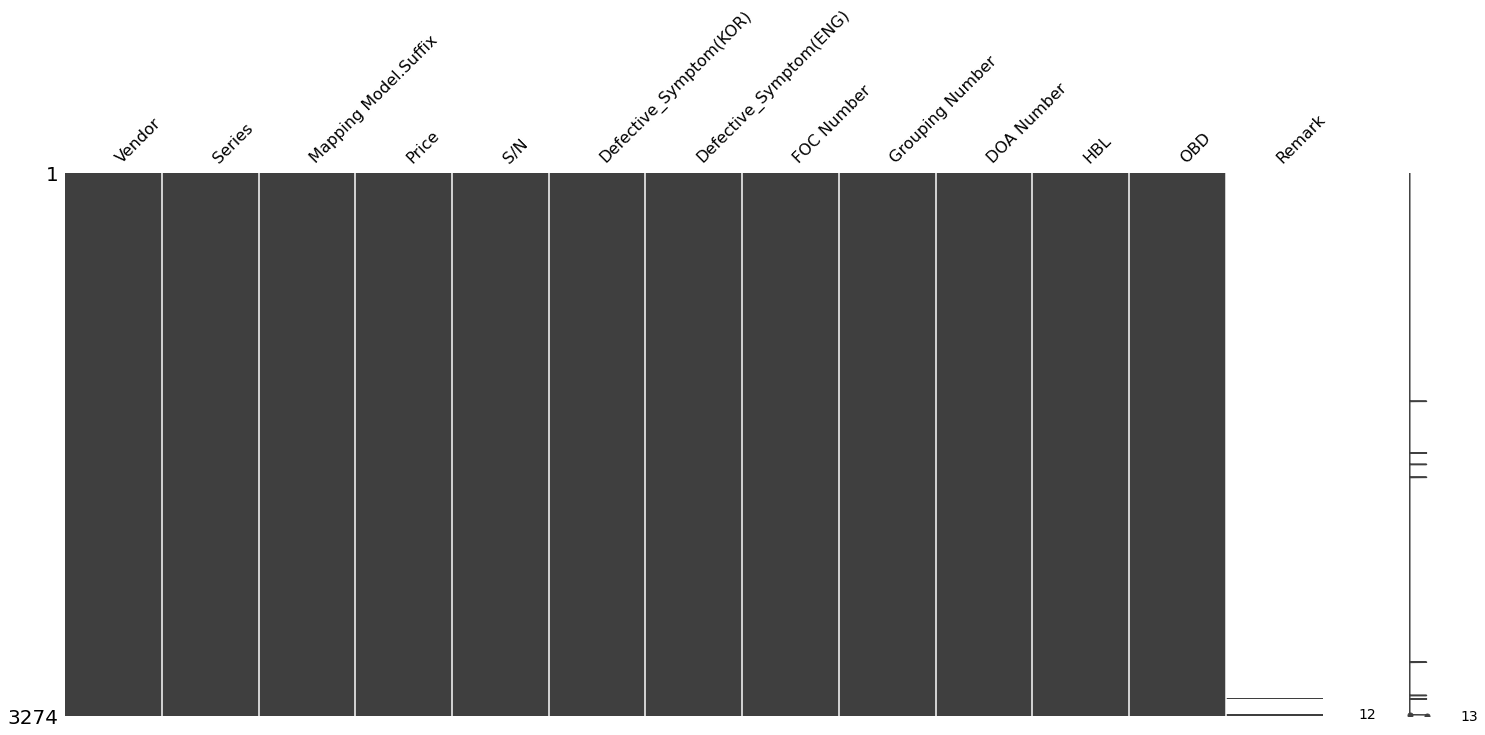

In [6]:
msno.matrix(df)

## 2. 신규 DOA 파일을 가져와서 불량내용을 영문 번역

In [2]:
# 권혁호 주임 불량 현황 엑셀파일 불러옴
df_new = pd.read_excel(get_filename(), sheet_name='Sheet1')
df_new = df_new[['분류', '모델', 'S/N', '비고']]
df_new.columns  = ['Vendor', 'Mapping Model.Suffix', 'S/N', 'Defective_Symptom(KOR)']
df_new = df_new.dropna(how='all')
df_new = df_new[~(df_new['Vendor'] == '남경')]
df_new.groupby('Vendor')['S/N'].count() # 물류에서 관리하는 파일 기준, 업체별 불량 수량 확인

Vendor
Pegatron     14
Quanta      524
W             9
Name: S/N, dtype: int64

In [3]:
# 모델과 Vendor과 잘 mapping 되었는지 2차 확인용
df_new['Mapping Model.Suffix'] = df_new['Mapping Model.Suffix'].str.strip()
df_new['S/N'] = df_new['S/N'].str.strip()
df_new.insert(1, 'Series', df_new['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model))
df_new['Vendor_check'] = df_new['Series'].replace(vendor_find)
df_new.groupby('Vendor_check')['S/N'].count()

Vendor_check
Pegatron     14
Quanta      524
Wingtech      9
Name: S/N, dtype: int64

In [5]:
df_new[~df_new['S/N'].str.contains(odm_sn)] # S/N이 PC odm모델의 S/N 표현으로 되어 있지 않은 것 확인

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check
538,W,10A30Q,10A30Q-L.AQ14K,207WIBF002197,전면 카메라 하단 압박시 소음,Wingtech
539,W,10A30Q,10A30Q-L.AQ14K,207WITM004081,LCD Scratch,Wingtech
540,W,10A30Q,10A30Q-L.AQ14K,207WIUU000054,후면 Deco부 얼룩,Wingtech
541,W,10A30Q,10A30Q-L.AQ14K,207WIXV001498,전면 카메라 하단 압박시 소음,Wingtech
542,W,10A30Q,10A30Q-L.AQ14ML,211WIPB000840,Back Cover 얼룩,Wingtech
543,W,10A30Q,10A30Q-L.AQ28K,207WIAE000848,Bottom면 얼룩,Wingtech
544,W,10A30Q,10A30Q-L.AQ28K,207WILC000936,LCD 백점,Wingtech
545,W,10A30Q,10A30Q-L.AQ28K,301WIYR000314,LCD 백점,Wingtech
546,W,10A30Q,10A30Q-L.AQ48KN,207WILC000792,Bottom면 얼룩,Wingtech


In [6]:
df_new.head(3)

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor_check
0,Pegatron,17U70Q,17U70Q-G.ARLGL,302PGCD810467,LCD Open/Close Noise,Pegatron
1,Pegatron,17U70Q,17U70Q-G.ARLGL,302PGNB810503,LCD Open/Close Noise,Pegatron
2,Pegatron,17U70Q,17U70Q-G.ARLGL,303PGCD816235,LCD 좌측 하단 가로줄,Pegatron


In [7]:
df_new = df_new.drop(columns='Vendor')

In [8]:
df_new.shape

(547, 5)

In [11]:
df_new = df_new.rename(columns={'Vendor_check':'Vendor'})
c1 = df_new['Vendor'].isin(['Pegatron', 'Quanta'])
df_new = df_new[c1]
df_new.shape

(538, 5)

In [12]:
df_new.groupby('Vendor')['Mapping Model.Suffix'].count()

Vendor
Pegatron     14
Quanta      524
Name: Mapping Model.Suffix, dtype: int64

In [17]:
vendor = 'Pegatron'
df_new = df_new[df_new['Vendor'] == vendor] # 원하는 업체명만 필터링함

In [19]:
df_new['Defective_Symptom(KOR)'] = df_new['Defective_Symptom(KOR)'].str.replace('\n', ',') # 불량 내용 문자열 중 개행 문자를 쉼표로 변경

C:\Users\paul76.lee\AppData\Local\Temp/ipykernel_18328/3475534693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Defective_Symptom(KOR)'] = df_new['Defective_Symptom(KOR)'].str.replace('\n', ',') # 불량 내용 문자열 중 개행 문자를 쉼표로 변경


In [22]:
df_new['Defective_Symptom(ENG)'] = df_new['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])

C:\Users\paul76.lee\AppData\Local\Temp/ipykernel_18328/2749380508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Defective_Symptom(ENG)'] = df_new['Defective_Symptom(KOR)'].apply(get_google_translate, args=['en'])


In [23]:
df_new[['Defective_Symptom(KOR)', 'Defective_Symptom(ENG)']].iloc[:] # 번역잘 되었는지 확인

,Defective_Symptom(KOR),Defective_Symptom(ENG)
0,LCD Open/Close Noise,LCD Open/Close Noise
1,LCD Open/Close Noise,LCD Open/Close Noise
2,LCD 좌측 하단 가로줄,Horizontal line at the bottom left of the LCD
3,Hinge Cap-L Dent,Hinge Cap-L Dent
4,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm
5,평탄도 불량 좌 1.2mm,Flatness defect Left 1.2mm
6,평탄도 불량 좌 1.1mm,Flatness defect Left 1.1mm
7,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm
8,LCD Open / Close 소음,LCD Open / Close Noise
9,D-Part 얼룩,D-Part stain


### ODM 업체로 보낼 파일 생성

In [24]:
today = datetime.date.today()
df_new.to_excel(f'D:/Python result/{today.isoformat()}_{vendor}_DOA.xlsx')

### 엑셀 DOA 발송 리스트 불러오기

In [5]:
df_new = pd.read_excel(get_filename(), sheet_name='DOA list')
df_new

## DB에 추가

In [10]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    df = pickle.load(f)

In [11]:
df.shape

(3424, 13)

In [10]:
df = pd.concat([df, df_new]).reset_index(drop=True)
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405,Quanta,16T90R,16TD90R-G.AX76K,850.43,07299303QCFT567611,B-Part 하단 들뜸 (우측),Lifting of the lower part of B-Part (right),F1000207964,CPCZ2304060005,N5V230310H-391L,NaN,NaT,NaN
3406,Quanta,16T90R,16TD90R-G.AX76K,850.43,07299303QCJZ567564,"B-Part 하단 들뜸 (우측),펜 시트 구겨짐","B-Part bottom lifted (right), pen sheet wrinkled",F1000207964,CPCZ2304060005,N5V230310H-391L,NaN,NaT,NaN
3407,Quanta,16T90Q,16TG90Q-G.AA75KN,851.49,302QCQX571116,C-Part Dent,C-Part Dent,F1000207964,CPCZ2304060005,N5V230310H-391L,NaN,NaT,NaN
3408,Quanta,14T90R,14T90R-G.AA50K,723.38,96462303QCAS559040,LCD 백점,LCD white point,F1000207964,CPCZ2304060005,N5V230310H-391L,NaN,NaT,NaN


In [11]:
df.shape

(3410, 13)

In [ ]:
# Futher analysis needed set marking
snlist = ['203QCRN577110']

In [14]:
df.fillna('N/A').groupby(['Vendor', 'DOA Number', 'OBD','HBL'])['S/N'].count()

Vendor    DOA Number       OBD                  HBL           
Pegatron  LG211006         2021-10-12 00:00:00  SMCIA216103        35
          LG211102         2021-11-09 00:00:00  SMCIA216793        26
          LG211201         2021-12-09 00:00:00  SMCIA217762        63
          LG220304         2022-03-17 00:00:00  SEL-0052 9817      51
          LG220510         2022-05-25 00:00:00  SEL-0053 5903      27
          LG220721         2022-08-01 00:00:00  SEL-0054 0419      39
          LG220818         2022-09-01 00:00:00  988-40865871      562
          LG221017         2022-10-23 00:00:00  SEL-0054 5900      42
          LG221108         2022-11-13 00:00:00  5501 1591 8253     45
          LG230308         2023-03-18 00:00:00  SEL-0055 9015      10
Quanta    N5T21916H-391    2021-10-07 00:00:00  SMCIA215936         8
          N5V21927H-391    2021-10-12 00:00:00  SMCIA216102       312
          N5V21B08H-391    2021-11-18 00:00:00  SMCIA217109       137
          N5V21B24H-391L   

In [15]:
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## DOA/FOC/CC grouping No update

In [30]:
foc = 'F1000207964'
cc_group = 'CPCZ2304060005'
doa = 'N5V230310H-391L'

In [33]:
df['FOC Number'] = foc
df['Grouping Number'] = cc_group

In [36]:
df

,Vendor,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),Price,DOA Number,FOC Number,Grouping Number
0,Quanta,11TG50Q,11TG50Q-E.AC10KN,206QCAS574704,T/Pad Button-L 둔감,T/Pad Button-L insensitive,287.40,N5V230310H-391L,F1000207964,CPCZ2304060005
1,Quanta,11TG50Q,11TG50Q-E.AC10KN,206QCAS574848,T/Pad Button 간헐적 무감,T/Pad Button intermittent insensitivity,287.40,N5V230310H-391L,F1000207964,CPCZ2304060005
2,Quanta,11TG50Q,11TG50Q-E.AC10KN,206QCEA574940,LCD 빛샘,LCD light leak,287.40,N5V230310H-391L,F1000207964,CPCZ2304060005
3,Quanta,11TG50Q,11TG50Q-E.AC10KN,206QCPY574616,LCD Open/Close Noise,LCD Open/Close Noise,287.40,N5V230310H-391L,F1000207964,CPCZ2304060005
4,Quanta,11TG50Q,11TG50Q-E.AC10KN,206QCRN574638,LCD 빛샘,LCD light leak,287.40,N5V230310H-391L,F1000207964,CPCZ2304060005
...,...,...,...,...,...,...,...,...,...,...
131,Quanta,16T90R,16TD90R-G.AX76K,07299303QCFT567611,B-Part 하단 들뜸 (우측),Lifting of the lower part of B-Part (right),850.43,N5V230310H-391L,F1000207964,CPCZ2304060005
132,Quanta,16T90R,16TD90R-G.AX76K,07299303QCJZ567564,"B-Part 하단 들뜸 (우측),펜 시트 구겨짐","B-Part bottom lifted (right), pen sheet wrinkled",850.43,N5V230310H-391L,F1000207964,CPCZ2304060005
133,Quanta,16T90Q,16TG90Q-G.AA75KN,302QCQX571116,C-Part Dent,C-Part Dent,851.49,N5V230310H-391L,F1000207964,CPCZ2304060005
134,Quanta,14T90R,14T90R-G.AA50K,96462303QCAS559040,LCD 백점,LCD white point,723.38,N5V230310H-391L,F1000207964,CPCZ2304060005


In [37]:
df.to_clipboard()

In [38]:
c1 =  df['FOC Number'].isnull()
c2 = df['DOA Number'] == 'N5V230310H-391L'
df.loc[c1 & c2, ['FOC Number', 'Grouping Number']] = (foc, cc_group)

In [39]:
df[c1]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3264,Pegatron,13U70Q,13U70Q-G.AR5SK,510.15,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3265,Pegatron,13U70Q,13UD70Q-G.AX50K,509.44,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3266,Pegatron,14T30Q,14T30Q-E.A310ML,335.84,211PGCD796803,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3267,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,208PGZU771965,Alt Key Scratch,Alt Key Scratch,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3268,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGAG775344,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3269,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3270,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGDX802266,LCD 가로줄,LCD horizontal line,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3271,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGZU801781,LCD 백점,LCD white spot,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3272,Pegatron,14T30Q,14TW30Q-E.AO14ML,331.54,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3273,Pegatron,17U70Q,17U70Q-P.AR50K,843.48,206PGLQ735640,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA


In [41]:
c1 = (df['Vendor'] == vendor)
c2 = (df['RMA Number'] == rma)

In [58]:
# 변경할 데이타 확인
df.loc[c1&c2, ['RMA Number', 'FOC Number', 'Grouping Number']]

,RMA Number,FOC Number,Grouping Number
2943,N5V22A08H-391L,NaN,NaN
2944,N5V22A08H-391L,NaN,NaN
2945,N5V22A08H-391L,NaN,NaN
2946,N5V22A08H-391L,NaN,NaN
2947,N5V22A08H-391L,NaN,NaN
...,...,...,...
3057,N5V22A08H-391L,NaN,NaN
3058,N5V22A08H-391L,NaN,NaN
3059,N5V22A08H-391L,NaN,NaN
3060,N5V22A08H-391L,NaN,NaN


In [60]:
#데이타 수정
df.loc[c1&c2, ['FOC Number', 'Grouping Number']] = [foc, cc_group]

In [62]:
# 변경되었는지 확인
df.loc[c1&c2, ['RMA Number', 'FOC Number', 'Grouping Number']]

,RMA Number,FOC Number,Grouping Number
2943,N5V22A08H-391L,F1000202340,CPCZ2210170001
2944,N5V22A08H-391L,F1000202340,CPCZ2210170001
2945,N5V22A08H-391L,F1000202340,CPCZ2210170001
2946,N5V22A08H-391L,F1000202340,CPCZ2210170001
2947,N5V22A08H-391L,F1000202340,CPCZ2210170001
...,...,...,...
3057,N5V22A08H-391L,F1000202340,CPCZ2210170001
3058,N5V22A08H-391L,F1000202340,CPCZ2210170001
3059,N5V22A08H-391L,F1000202340,CPCZ2210170001
3060,N5V22A08H-391L,F1000202340,CPCZ2210170001


## 3. 선적 정보 update

In [5]:
df[df['Vendor'] == 'Quanta']['HBL'].unique()

array(['SMCIA215936', 'SMCIA216102', 'SMCIA217109', 'SMCIA217546',
       'SMCIA218236', 'SMCIA220491', 'SEL-0053 2825', 'SEL-0053 4511',
       'SEL-0053 8703', 'SEL-0054 0418', '112-64178870', 'SEL-0054 5657',
       '550115928366', 'SEL-0055 2553'], dtype=object)

In [6]:
BL = 'SEL-0055 9015'
obd = datetime.datetime(2023, 3, 18)

In [9]:
c1 = df['Vendor'] == 'Pegatron'
c2 = df['HBL'].isnull()
df[c1 & c2]

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
3264,Pegatron,13U70Q,13U70Q-G.AR5SK,510.15,205PGAG722056,LCD 우측 상단 쳐짐,Upper right corner of the LCD is sagging,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3265,Pegatron,13U70Q,13UD70Q-G.AX50K,509.44,111PGUH617286,"평탄도 불량, B-Part Scratch","Poor flatness, B-Part scratch",F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3266,Pegatron,14T30Q,14T30Q-E.A310ML,335.84,211PGCD796803,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3267,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,208PGZU771965,Alt Key Scratch,Alt Key Scratch,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3268,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGAG775344,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3269,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,209PGGE774039,보이스레코더 음성 녹음 노이즈,voice recorder voice recording noise,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3270,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGDX802266,LCD 가로줄,LCD horizontal line,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3271,Pegatron,14T30Q,14TN30Q-E.AO14KN,332.54,212PGZU801781,LCD 백점,LCD white spot,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3272,Pegatron,14T30Q,14TW30Q-E.AO14ML,331.54,209PGEF773612,Box 오 적용(Whale Book 인쇄무),Box misapplied (whale book not printed),F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA
3273,Pegatron,17U70Q,17U70Q-P.AR50K,843.48,206PGLQ735640,Box 불량,Box bad,F1000207121,CPCZ2303140001,LG230308,NaN,NaT,DOA


In [14]:
df.loc[c1 & c2, ['HBL', 'OBD']] = (BL, obd)

,HBL,OBD
3264,SEL-0055 9015,2023-03-18
3265,SEL-0055 9015,2023-03-18
3266,SEL-0055 9015,2023-03-18
3267,SEL-0055 9015,2023-03-18
3268,SEL-0055 9015,2023-03-18
3269,SEL-0055 9015,2023-03-18
3270,SEL-0055 9015,2023-03-18
3271,SEL-0055 9015,2023-03-18
3272,SEL-0055 9015,2023-03-18
3273,SEL-0055 9015,2023-03-18


In [15]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(df, f)

## 최종 Packing 완료된 기준의 DOA 리스트를 불러옴

In [3]:
df = pd.read_excel(get_filename(), sheet_name='Sheet1')
df

,Series,Mapping Model.Suffix,S/N,Defective_Symptom(KOR),Vendor,Defective_Symptom(ENG)
0,17U70Q,17U70Q-G.ARLGL,302PGCD810467,LCD Open/Close Noise,Pegatron,LCD Open/Close Noise
1,17U70Q,17U70Q-G.ARLGL,302PGNB810503,LCD Open/Close Noise,Pegatron,LCD Open/Close Noise
2,17U70Q,17U70Q-G.ARLGL,303PGCD816235,LCD 좌측 하단 가로줄,Pegatron,Horizontal line at the bottom left of the LCD
3,17U70Q,17U70Q-G.ARLGL,303PGPM816472,Hinge Cap-L Dent,Pegatron,Hinge Cap-L Dent
4,17U70Q,17UD70Q-P.AX70K,72608303PGCD815827,평탄도 불량 좌 1.0mm,Pegatron,Flatness defect Left 1.0mm
5,17U70Q,17UD70Q-P.AX70K,72608303PGFJ816011,평탄도 불량 좌 1.2mm,Pegatron,Flatness defect Left 1.2mm
6,17U70Q,17UD70Q-P.AX70K,72608303PGHT815585,평탄도 불량 좌 1.1mm,Pegatron,Flatness defect Left 1.1mm
7,17U70Q,17UD70Q-P.AX70K,72608303PGJK815916,평탄도 불량 좌 1.0mm,Pegatron,Flatness defect Left 1.0mm
8,17U70Q,17UD70Q-P.AX70K,72608303PGKW815621,LCD Open / Close 소음,Pegatron,LCD Open / Close Noise
9,17U70Q,17UD70Q-P.AX70K,72608303PGMP815907,D-Part 얼룩,Pegatron,D-Part stain


In [4]:
with open('D:/Data/PC ODM DOA return DB.bin', 'rb') as f:
    doa = pickle.load(f)

In [5]:
doa.groupby(['Vendor', 'OBD'],dropna=False)['S/N'].count()

Vendor    OBD       
Pegatron  2021-10-12     35
          2021-11-09     26
          2021-12-09     63
          2022-03-17     51
          2022-05-25     27
          2022-08-01     39
          2022-09-01    562
          2022-10-23     42
          2022-11-13     45
          2023-03-18     10
Quanta    2021-10-07      8
          2021-10-12    312
          2021-11-18    137
          2021-12-02     47
          2021-12-23    121
          2022-01-20    217
          2022-04-14    261
          2022-05-25    373
          2022-07-03     79
          2022-08-01    119
          2022-08-26    466
          2022-10-20    119
          2022-11-20     37
          2022-12-14     78
          NaT           136
Name: S/N, dtype: int64

In [6]:
df = pd.concat([pd.DataFrame(columns=doa.columns), df])
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Pegatron,17U70Q,17U70Q-G.ARLGL,NaN,302PGCD810467,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,NaN,NaN,NaN,NaN
1,Pegatron,17U70Q,17U70Q-G.ARLGL,NaN,302PGNB810503,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,NaN,NaN,NaN,NaN
2,Pegatron,17U70Q,17U70Q-G.ARLGL,NaN,303PGCD816235,LCD 좌측 하단 가로줄,Horizontal line at the bottom left of the LCD,NaN,NaN,NaN,NaN,NaN,NaN
3,Pegatron,17U70Q,17U70Q-G.ARLGL,NaN,303PGPM816472,Hinge Cap-L Dent,Hinge Cap-L Dent,NaN,NaN,NaN,NaN,NaN,NaN
4,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGCD815827,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,NaN,NaN,NaN,NaN,NaN,NaN
5,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGFJ816011,평탄도 불량 좌 1.2mm,Flatness defect Left 1.2mm,NaN,NaN,NaN,NaN,NaN,NaN
6,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGHT815585,평탄도 불량 좌 1.1mm,Flatness defect Left 1.1mm,NaN,NaN,NaN,NaN,NaN,NaN
7,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGJK815916,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,NaN,NaN,NaN,NaN,NaN,NaN
8,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGKW815621,LCD Open / Close 소음,LCD Open / Close Noise,NaN,NaN,NaN,NaN,NaN,NaN
9,Pegatron,17U70Q,17UD70Q-P.AX70K,NaN,72608303PGMP815907,D-Part 얼룩,D-Part stain,NaN,NaN,NaN,NaN,NaN,NaN


## 4. 최신 사입가로 업데이트

In [18]:
df = df_new.copy()

In [19]:
df['Price'] = np.nan

In [8]:
vendor = 'Pegatron' # 최신 사입가를 받아올 업체 선택
with open(f'D:/Data/{vendor} PO DB.bin', 'rb') as f: # Quanta PO DB를 불러옴
    up_check = pickle.load(f)

lt_date = up_check.groupby('Mapping Model.Suffix')['Issued Date'].max() # PO DB에서 모델명별 최신 PO일자 정보를 만듬
up_check = up_check.set_index(['Mapping Model.Suffix', 'Issued Date']) # PO DB 조회하기 위해 모델명, PO발행일을 인덱스로 설정
lt_price = pd.Series() # 빈 시리즈만들고, Lopp돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성

for i in lt_date.index:
    lt_price.loc[i] = up_check.loc[(i, lt_date.loc[i]), 'Unit Price'].max()
lt_price.name = 'Latest Unit Price'
lt_price

C:\Users\paul76.lee\AppData\Local\Temp/ipykernel_20052/1805528706.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lt_price = pd.Series() # 빈 시리즈만들고, Lopp돌며 모델별 최신일자의 사입가를 빈 시리즈에 작성


13U50N-G.AR56K    423.18
13U580-G.AA50K    406.82
13U580-G.AR30K    338.82
13U580-L.AR10K    280.82
13U580-L.AR1EK    271.82
                   ...  
CL600W-AP.AEUQ    198.05
CL600W-AP.AKRQ    182.55
CL600W-AP.AUBQ    168.57
CL600W-AQ.AEUQ    190.40
CL600W-AQ.AKRQ    174.90
Name: Latest Unit Price, Length: 244, dtype: float64

In [9]:
df.loc[df['Price'].isnull(), 'Price'] = df.loc[df['Price'].isnull(), 'Mapping Model.Suffix'].map(lt_price) # 가격이 없는 행에 최신가격 업데이트

In [10]:
df[df['Price'].isnull()]['Mapping Model.Suffix'].str.len()

Series([], Name: Mapping Model.Suffix, dtype: int64)

In [11]:
df['DOA Number'] = 'LG20230410'

In [12]:
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,302PGCD810467,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,LG20230410,NaN,NaN,NaN
1,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,302PGNB810503,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,LG20230410,NaN,NaN,NaN
2,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,303PGCD816235,LCD 좌측 하단 가로줄,Horizontal line at the bottom left of the LCD,NaN,NaN,LG20230410,NaN,NaN,NaN
3,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,303PGPM816472,Hinge Cap-L Dent,Hinge Cap-L Dent,NaN,NaN,LG20230410,NaN,NaN,NaN
4,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGCD815827,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,NaN,NaN,LG20230410,NaN,NaN,NaN
5,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGFJ816011,평탄도 불량 좌 1.2mm,Flatness defect Left 1.2mm,NaN,NaN,LG20230410,NaN,NaN,NaN
6,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGHT815585,평탄도 불량 좌 1.1mm,Flatness defect Left 1.1mm,NaN,NaN,LG20230410,NaN,NaN,NaN
7,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGJK815916,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,NaN,NaN,LG20230410,NaN,NaN,NaN
8,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGKW815621,LCD Open / Close 소음,LCD Open / Close Noise,NaN,NaN,LG20230410,NaN,NaN,NaN
9,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGMP815907,D-Part 얼룩,D-Part stain,NaN,NaN,LG20230410,NaN,NaN,NaN


### 나봉훈 기정님 Packing 정보 변환

In [13]:
packing = pd.read_clipboard() # 나봉훈 기정님 공유한 packing 정보 복사하여 읽어오기

new_list = []
for name in packing.columns:
    if '\xa0' in name:
        new_list.append(name.replace('\xa0', ''))
    else:
        new_list.append(name)
packing.columns = new_list

packing = packing.rename(columns={'수량':'Pallet', '가로(cm)':'Width(cm)', '세로(cm)':'Depth(cm)',
                        '높이(cm)':'Height(cm)', '무게(kg)':'Gross Weight(Kg)', '포장단위(EA)':'Carton Qty'})
packing['Width(m)'] = packing['Width(cm)'] / 100
packing['Depth(m)'] = packing['Depth(cm)'] / 100
packing['Height(m)'] = packing['Height(cm)'] / 100
packing['Net Weight(Kg)'] = packing['Gross Weight(Kg)'] - 10
packing['CBM'] = packing['Width(m)'] * packing['Depth(m)'] * packing['Height(m)']
packing.to_clipboard(index=False)
packing

,Pallet,Width(cm),Depth(cm),Height(cm),Gross Weight(Kg),Carton Qty,Width(m),Depth(m),Height(m),Net Weight(Kg),CBM
0,(1) 14 EA,120,100,47,64,1*14=14ea,1.2,1.0,0.47,54,0.564


In [14]:
packing.to_clipboard()

In [16]:
df.pivot_table('S/N', index=['Mapping Model.Suffix', 'Price'], aggfunc='count').reset_index().to_clipboard()

In [18]:
doa.pivot_table('S/N', index=['Vendor', 'FOC Number','OBD'], aggfunc='count')

S/N
Vendor   FOC Number  OBD            
Pegatron F1000190536 2021-10-12   35
         F1000191443 2021-11-09   26
         F1000192504 2021-12-09   63
         F1000195153 2022-03-17   51
         F1000197493 2022-05-25   27
         F1000199890 2022-08-01   39
         F1000200869 2022-09-01  562
         F1000202530 2022-10-23   42
         F1000203191 2022-11-13   45
         F1000207121 2023-03-18   10
Quanta   F1000190204 2021-10-07    8
         F1000190524 2021-10-12  312
         F1000191764 2021-11-18  137
         F1000192308 2021-12-02   47
         F1000192987 2021-12-23  121
         F1000193650 2022-01-20  217
         F1000195776 2022-04-14  261
         F1000197491 2022-05-25  373
         F1000198527 2022-07-03   79
         F1000199889 2022-08-01  119
         F1000200529 2022-08-26  466
         F1000202340 2022-10-20  119
         F1000203479 2022-11-20   37
         F1000204203 2022-12-14   78

In [19]:
foc = 'F1000208058'
group = 'CPCZ2304110002'

In [21]:
df['FOC Number'] = foc
df['Grouping Number'] = group
df

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,302PGCD810467,LCD Open/Close Noise,LCD Open/Close Noise,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
1,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,302PGNB810503,LCD Open/Close Noise,LCD Open/Close Noise,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
2,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,303PGCD816235,LCD 좌측 하단 가로줄,Horizontal line at the bottom left of the LCD,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
3,Pegatron,17U70Q,17U70Q-G.ARLGL,594.97,303PGPM816472,Hinge Cap-L Dent,Hinge Cap-L Dent,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
4,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGCD815827,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
5,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGFJ816011,평탄도 불량 좌 1.2mm,Flatness defect Left 1.2mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
6,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGHT815585,평탄도 불량 좌 1.1mm,Flatness defect Left 1.1mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
7,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGJK815916,평탄도 불량 좌 1.0mm,Flatness defect Left 1.0mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
8,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGKW815621,LCD Open / Close 소음,LCD Open / Close Noise,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
9,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGMP815907,D-Part 얼룩,D-Part stain,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN


In [23]:
doa = pd.concat([doa, df])
doa = doa.reset_index(drop=True)
doa

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,DOA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGMP815907,D-Part 얼룩,D-Part stain,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
3420,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGRS815774,평탄도 불량 좌 0.7mm,Flatness defect Left 0.7mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
3421,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGTV815689,평탄도 불량 좌 0.6mm,Flatness defect Left 0.6mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN
3422,Pegatron,17U70Q,17UD70Q-P.AX70K,930.05,72608303PGUH815814,평탄도 불량 좌 0.8mm,Flatness defect Left 0.8mm,F1000208058,CPCZ2304110002,LG20230410,NaN,NaN,NaN


## 5. 신규 DOA 데이타를 기존 DB에 업데이트

### DOA 세트 추가 발생시 DB에 추가

In [10]:
df_add = pd.read_excel(get_filename(), sheet_name=1)
df_add

,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCAS574800,간헐적 인터넷 끊김,Intermittent Internet Loss,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
1,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCEA574724,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
2,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCGW574767,C-Part Scratch,C-Part Scratch,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCGW574815,D-Part Scratch,D-Part Scratch,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
4,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCHE566289,제품 내부 소음,product internal noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
5,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCLH574672,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
6,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCLH574720,KBD Alt Key 복원 느림,KBD Alt Key restore slow,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
7,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCPY574616,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
8,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCRN574638,화면 회전 안됨,Screen not rotating,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
9,Quanta,11T50Q,11TG50Q-E.AC10KN,300.17,206QCSF574694,LCD Open/Close Noise,LCD Open/Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN


In [19]:
rma_num = 'N5V22B10H-391L'

df = pd.concat([df, df_add[~df_add['S/N'].isin(df[df['RMA Number'] == rma_num]['S/N'])]]).reset_index(drop=True)
df


,Vendor,Series,Mapping Model.Suffix,Price,S/N,Defective_Symptom(KOR),Defective_Symptom(ENG),FOC Number,Grouping Number,RMA Number,HBL,OBD,Remark
0,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCKJ561821,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
1,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCDG561818,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
2,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCCV561787,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
3,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCSF561790,FAN 소음,FAN abnormal noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
4,Quanta,15U40Q,15U40Q-G.AR30K,329.4,108QCZP561837,LCD Open/close 소음,LCD open/close noise,F1000190204,CPCZ2109280001,N5T21916H-391,SMCIA215936,2021-10-07 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,Quanta,16T90P,16TG90P-G.AR5DKN,NaN,209QCMR558547,D-Part 소음 (우측 Touch시 삐걱소음),D-Part noise (squeaking noise when right touch),NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3182,Quanta,16T90P,16TG90P-G.AR5DKN,NaN,209QCNL558647,Open / Close 소음,Open / Close Noise,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3183,Quanta,15U50Q,15UD50Q-G.AX50K,NaN,210QCFT561371,KBD Space Bar Noise 불량,KBD Space Bar Noise defect,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN
3184,Quanta,15U50Q,15UD50Q-G.AX50K,NaN,210QCFT561251,KBD Space Bar Noise 불량,KBD Space Bar Noise defect,NaN,NaN,N5V22B10H-391L,NaN,NaN,NaN


In [30]:
df[df['RMA Number']==rma_num].to_excel('D:/Python result/221116_Quanta new DOA 37 pcs.xlsx')

In [25]:
# 최종 결과를 DB에 저장
with open('D:/Data/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(doa, f)

In [26]:
# 최종 결과를 DB back up에도 저장
with open('D:/Data/DB backup/PC ODM DOA return DB.bin', 'wb') as f:
    pickle.dump(doa, f)